In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Para la barra de progreso
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc

# Montamos la unidad de drive y trabajamos con los datasets y modelos preparados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_clinicalData = '/content/drive/MyDrive/output/CMMD_clinicaldata_revision.xlsx'
clinicaldataDF = pd.read_excel(ruta_clinicalData)

In [ ]:
ruta_metadata = '/content/drive/MyDrive/output/metadata.csv'
metadataDF = pd.read_csv(ruta_metadata)

In [ ]:
models_list = []
train_losses_list = []
train_accuracies_list = []
val_losses_list = []
val_accuracies_list = []

In [ ]:
X_tensor = torch.load("/content/drive/MyDrive/output/X_oversampled.pt")
y_tensor = torch.load("/content/drive/MyDrive/output/y_oversampled.pt")

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=42)

In [ ]:
print("Conjunto de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", y_train.shape)
print("Conjunto de prueba:", X_test.shape)
print("Etiquetas de prueba:", y_test.shape)

Conjunto de entrenamiento: torch.Size([6550, 1, 224, 224])
Etiquetas de entrenamiento: torch.Size([6550])
Conjunto de prueba: torch.Size([1638, 1, 224, 224])
Etiquetas de prueba: torch.Size([1638])


In [ ]:
# Dataset y DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Número total de parámetros entrenables:", total_params)

Número total de parámetros entrenables: 3451777


In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()

        # Primera capa
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Normalización por lotes
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)  # Dropout para reducir el sobreajuste
        )

        # Segunda capa
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Tercera capa
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Cuarta capa
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Clasificador con Dropout y Batch Normalization
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = EnhancedCNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Número total de parámetros entrenables:", total_params)

Número total de parámetros entrenables: 13234881


In [ ]:
# @title Funciones generales (callbacks, entrenar, métricas)
## Definición de clase para el callback "Early Stopping"
class EarlyStopping:
    def __init__(self, path, patience=3, verbose=False, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = float('inf')
        self.path = path  # Archivo donde guardaremos el modelo

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping no mejoró en {self.counter} épocas')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss mejorada a {val_loss:.6f}. Guardando modelo...')
            torch.save(model, self.path)
            self.val_loss_min = val_loss

def trainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Bucle para cada época
    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        correct_train = 0
        total_train = 0

        model.train()

        # Bucle de entrenamiento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Precisión del entrenamiento
            predicted = torch.sigmoid(outputs)  # Aplicar sigmoide
            predicted = (predicted > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().view(-1, 1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Precisión de validación
                predicted = torch.sigmoid(outputs)
                predicted = (predicted > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_duration = end_time - start_time  # Duración de la época

        print(f"Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_duration:.2f} seconds")

        # Aplicar Early Stopping y guardar modelo si corresponde
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early Stopping activado. Proceso detenido!")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

def metrics(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    binary_preds = (all_preds > 0.5).astype(int)

    conf_matrix = confusion_matrix(all_labels, binary_preds)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicciones')
    plt.ylabel('Realidad')
    plt.title('Matriz de Confusión - Existencia de cáncer')
    plt.show()

    accuracy = accuracy_score(all_labels, binary_preds)
    report = classification_report(all_labels, binary_preds, target_names=['Negativo', 'Positivo'])

    print(f"Precisión global: {accuracy * 100:.2f}%")
    print("\nInforme y métricas de clasificación:")
    print(report)

    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    accuracy = accuracy_score(all_labels, binary_preds)

    print(f"Precisión: {precision:.2f}")
    print(f"Sensibilidad (Recall): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    true_negatives = conf_matrix[0, 0]
    false_positives = conf_matrix[0, 1]
    true_positives = conf_matrix[1, 1]
    false_negatives = conf_matrix[1, 0]

    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Especificidad: {specificity:.2f}")

    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

def graphLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Model Loss')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
model = CNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/CNN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 409/409 [00:12<00:00, 31.77it/s]


Train Loss: 0.695, Train Accuracy: 49.19%, Val Loss: 0.6895, Val Accuracy: 52.21%, Time: 13.93 seconds
Validation loss mejorada a 0.689503. Guardando modelo...


Epoch 2/30: 100%|██████████| 409/409 [00:11<00:00, 36.73it/s]


Train Loss: 0.683, Train Accuracy: 54.68%, Val Loss: 0.6896, Val Accuracy: 56.25%, Time: 12.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 409/409 [00:11<00:00, 36.53it/s]


Train Loss: 0.642, Train Accuracy: 62.55%, Val Loss: 0.6282, Val Accuracy: 64.40%, Time: 12.28 seconds
Validation loss mejorada a 0.628189. Guardando modelo...


Epoch 4/30: 100%|██████████| 409/409 [00:11<00:00, 36.64it/s]


Train Loss: 0.523, Train Accuracy: 73.55%, Val Loss: 0.5204, Val Accuracy: 75.43%, Time: 12.23 seconds
Validation loss mejorada a 0.520422. Guardando modelo...


Epoch 5/30: 100%|██████████| 409/409 [00:11<00:00, 36.72it/s]


Train Loss: 0.318, Train Accuracy: 86.45%, Val Loss: 0.4780, Val Accuracy: 83.21%, Time: 12.21 seconds
Validation loss mejorada a 0.477990. Guardando modelo...


Epoch 6/30: 100%|██████████| 409/409 [00:11<00:00, 36.69it/s]


Train Loss: 0.151, Train Accuracy: 94.06%, Val Loss: 0.5118, Val Accuracy: 85.85%, Time: 12.20 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 7/30: 100%|██████████| 409/409 [00:11<00:00, 36.66it/s]


Train Loss: 0.077, Train Accuracy: 97.10%, Val Loss: 0.5472, Val Accuracy: 86.83%, Time: 12.23 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 8/30: 100%|██████████| 409/409 [00:11<00:00, 36.41it/s]


Train Loss: 0.028, Train Accuracy: 99.16%, Val Loss: 0.7106, Val Accuracy: 88.60%, Time: 12.30 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 9/30: 100%|██████████| 409/409 [00:11<00:00, 36.41it/s]


Train Loss: 0.026, Train Accuracy: 99.22%, Val Loss: 0.7498, Val Accuracy: 89.34%, Time: 12.31 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 10/30: 100%|██████████| 409/409 [00:11<00:00, 36.49it/s]


Train Loss: 0.026, Train Accuracy: 99.04%, Val Loss: 0.7630, Val Accuracy: 91.05%, Time: 12.29 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 11/30: 100%|██████████| 409/409 [00:11<00:00, 36.58it/s]


Train Loss: 0.026, Train Accuracy: 99.33%, Val Loss: 0.8963, Val Accuracy: 88.42%, Time: 12.25 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 12/30: 100%|██████████| 409/409 [00:11<00:00, 36.64it/s]


Train Loss: 0.014, Train Accuracy: 99.68%, Val Loss: 0.7372, Val Accuracy: 89.52%, Time: 12.23 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 13/30: 100%|██████████| 409/409 [00:11<00:00, 36.58it/s]


Train Loss: 0.012, Train Accuracy: 99.79%, Val Loss: 0.7093, Val Accuracy: 90.44%, Time: 12.26 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 14/30: 100%|██████████| 409/409 [00:11<00:00, 36.46it/s]


Train Loss: 0.016, Train Accuracy: 99.54%, Val Loss: 0.7765, Val Accuracy: 89.34%, Time: 12.29 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 15/30: 100%|██████████| 409/409 [00:11<00:00, 36.42it/s]


Train Loss: 0.010, Train Accuracy: 99.74%, Val Loss: 0.8249, Val Accuracy: 88.24%, Time: 12.30 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 16/30: 100%|██████████| 409/409 [00:11<00:00, 36.24it/s]


Train Loss: 0.005, Train Accuracy: 99.89%, Val Loss: 1.0242, Val Accuracy: 87.99%, Time: 12.36 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 17/30: 100%|██████████| 409/409 [00:11<00:00, 36.30it/s]


Train Loss: 0.017, Train Accuracy: 99.57%, Val Loss: 0.9367, Val Accuracy: 86.64%, Time: 12.34 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 18/30: 100%|██████████| 409/409 [00:11<00:00, 36.34it/s]


Train Loss: 0.029, Train Accuracy: 99.19%, Val Loss: 0.7420, Val Accuracy: 88.54%, Time: 12.32 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 19/30: 100%|██████████| 409/409 [00:11<00:00, 36.31it/s]


Train Loss: 0.011, Train Accuracy: 99.65%, Val Loss: 0.7776, Val Accuracy: 89.58%, Time: 12.33 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 20/30: 100%|██████████| 409/409 [00:11<00:00, 36.14it/s]


Train Loss: 0.003, Train Accuracy: 99.94%, Val Loss: 1.0215, Val Accuracy: 87.93%, Time: 12.39 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


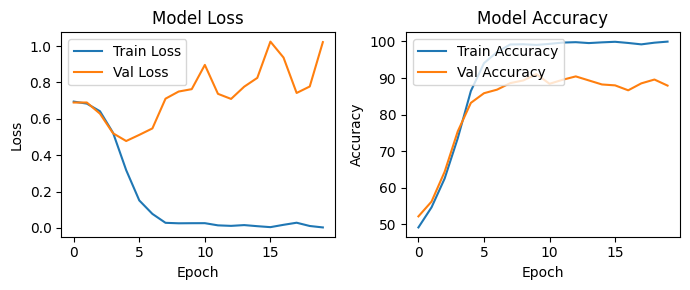

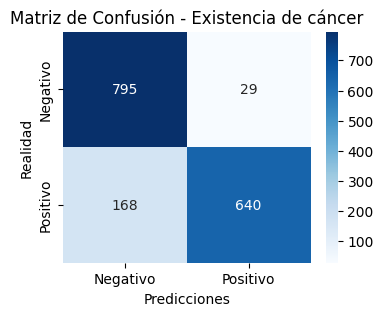

Precisión global: 87.93%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.83      0.96      0.89       824
    Positivo       0.96      0.79      0.87       808

    accuracy                           0.88      1632
   macro avg       0.89      0.88      0.88      1632
weighted avg       0.89      0.88      0.88      1632

Precisión: 0.96
Sensibilidad (Recall): 0.79
F1-Score: 0.87
Accuracy: 0.88
Especificidad: 0.96


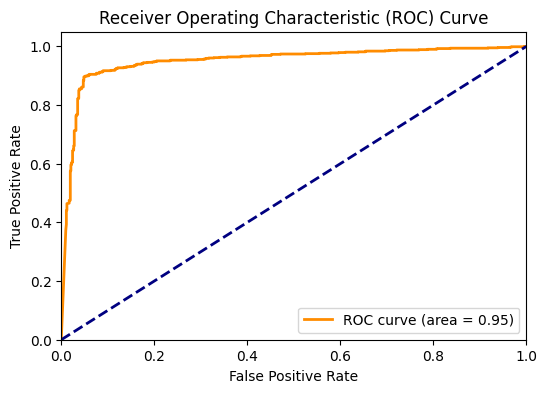

0.950318567961165

In [ ]:
models_list.append("CNN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/EnhancedCNN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 409/409 [00:17<00:00, 23.89it/s]


Train Loss: 0.700, Train Accuracy: 54.58%, Val Loss: 0.7065, Val Accuracy: 50.61%, Time: 18.45 seconds
Validation loss mejorada a 0.706458. Guardando modelo...


Epoch 2/30: 100%|██████████| 409/409 [00:17<00:00, 23.98it/s]


Train Loss: 0.677, Train Accuracy: 57.40%, Val Loss: 0.6814, Val Accuracy: 59.01%, Time: 18.37 seconds
Validation loss mejorada a 0.681377. Guardando modelo...


Epoch 3/30: 100%|██████████| 409/409 [00:17<00:00, 23.90it/s]


Train Loss: 0.666, Train Accuracy: 58.76%, Val Loss: 0.6670, Val Accuracy: 60.36%, Time: 18.43 seconds
Validation loss mejorada a 0.666954. Guardando modelo...


Epoch 4/30: 100%|██████████| 409/409 [00:16<00:00, 24.08it/s]


Train Loss: 0.655, Train Accuracy: 61.19%, Val Loss: 0.7971, Val Accuracy: 50.12%, Time: 18.30 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 5/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.642, Train Accuracy: 62.94%, Val Loss: 0.6505, Val Accuracy: 59.80%, Time: 18.22 seconds
Validation loss mejorada a 0.650472. Guardando modelo...


Epoch 6/30: 100%|██████████| 409/409 [00:16<00:00, 24.20it/s]


Train Loss: 0.627, Train Accuracy: 65.16%, Val Loss: 0.6542, Val Accuracy: 62.13%, Time: 18.20 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 7/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.604, Train Accuracy: 66.84%, Val Loss: 0.6539, Val Accuracy: 61.03%, Time: 18.23 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 8/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.571, Train Accuracy: 70.54%, Val Loss: 0.6702, Val Accuracy: 58.03%, Time: 18.23 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 9/30: 100%|██████████| 409/409 [00:16<00:00, 24.18it/s]


Train Loss: 0.530, Train Accuracy: 73.47%, Val Loss: 0.5403, Val Accuracy: 73.84%, Time: 18.21 seconds
Validation loss mejorada a 0.540318. Guardando modelo...


Epoch 10/30: 100%|██████████| 409/409 [00:16<00:00, 24.21it/s]


Train Loss: 0.483, Train Accuracy: 76.89%, Val Loss: 0.8374, Val Accuracy: 53.74%, Time: 18.20 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 11/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.432, Train Accuracy: 80.06%, Val Loss: 0.8787, Val Accuracy: 55.09%, Time: 18.22 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 12/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.394, Train Accuracy: 81.82%, Val Loss: 0.6558, Val Accuracy: 64.71%, Time: 18.23 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 13/30: 100%|██████████| 409/409 [00:16<00:00, 24.18it/s]


Train Loss: 0.354, Train Accuracy: 83.80%, Val Loss: 0.4528, Val Accuracy: 78.62%, Time: 18.21 seconds
Validation loss mejorada a 0.452801. Guardando modelo...


Epoch 14/30: 100%|██████████| 409/409 [00:16<00:00, 24.20it/s]


Train Loss: 0.325, Train Accuracy: 86.55%, Val Loss: 0.3692, Val Accuracy: 85.54%, Time: 18.20 seconds
Validation loss mejorada a 0.369177. Guardando modelo...


Epoch 15/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.295, Train Accuracy: 87.35%, Val Loss: 0.3597, Val Accuracy: 86.03%, Time: 18.29 seconds
Validation loss mejorada a 0.359668. Guardando modelo...


Epoch 16/30: 100%|██████████| 409/409 [00:16<00:00, 24.14it/s]


Train Loss: 0.262, Train Accuracy: 88.74%, Val Loss: 0.3362, Val Accuracy: 87.01%, Time: 18.27 seconds
Validation loss mejorada a 0.336163. Guardando modelo...


Epoch 17/30: 100%|██████████| 409/409 [00:16<00:00, 24.15it/s]


Train Loss: 0.244, Train Accuracy: 90.08%, Val Loss: 0.3748, Val Accuracy: 84.19%, Time: 18.24 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 18/30: 100%|██████████| 409/409 [00:16<00:00, 24.14it/s]


Train Loss: 0.225, Train Accuracy: 91.11%, Val Loss: 0.2994, Val Accuracy: 89.15%, Time: 18.24 seconds
Validation loss mejorada a 0.299404. Guardando modelo...


Epoch 19/30: 100%|██████████| 409/409 [00:16<00:00, 24.08it/s]


Train Loss: 0.205, Train Accuracy: 91.87%, Val Loss: 0.2626, Val Accuracy: 90.44%, Time: 18.29 seconds
Validation loss mejorada a 0.262589. Guardando modelo...


Epoch 20/30: 100%|██████████| 409/409 [00:16<00:00, 24.18it/s]


Train Loss: 0.202, Train Accuracy: 91.47%, Val Loss: 0.2481, Val Accuracy: 91.42%, Time: 18.22 seconds
Validation loss mejorada a 0.248073. Guardando modelo...


Epoch 21/30: 100%|██████████| 409/409 [00:16<00:00, 24.22it/s]


Train Loss: 0.190, Train Accuracy: 92.53%, Val Loss: 0.2576, Val Accuracy: 91.05%, Time: 18.20 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 22/30: 100%|██████████| 409/409 [00:16<00:00, 24.09it/s]


Train Loss: 0.161, Train Accuracy: 93.70%, Val Loss: 0.2411, Val Accuracy: 93.01%, Time: 18.31 seconds
Validation loss mejorada a 0.241145. Guardando modelo...


Epoch 23/30: 100%|██████████| 409/409 [00:16<00:00, 24.15it/s]


Train Loss: 0.164, Train Accuracy: 93.58%, Val Loss: 0.2679, Val Accuracy: 90.20%, Time: 18.24 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 24/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.153, Train Accuracy: 94.13%, Val Loss: 0.2076, Val Accuracy: 93.57%, Time: 18.23 seconds
Validation loss mejorada a 0.207635. Guardando modelo...


Epoch 25/30: 100%|██████████| 409/409 [00:16<00:00, 24.20it/s]


Train Loss: 0.138, Train Accuracy: 94.48%, Val Loss: 0.2343, Val Accuracy: 91.61%, Time: 18.22 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 26/30: 100%|██████████| 409/409 [00:16<00:00, 24.15it/s]


Train Loss: 0.127, Train Accuracy: 95.32%, Val Loss: 0.2391, Val Accuracy: 92.65%, Time: 18.25 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 27/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.133, Train Accuracy: 94.97%, Val Loss: 0.2054, Val Accuracy: 94.18%, Time: 18.23 seconds
Validation loss mejorada a 0.205446. Guardando modelo...


Epoch 28/30: 100%|██████████| 409/409 [00:16<00:00, 24.15it/s]


Train Loss: 0.134, Train Accuracy: 94.82%, Val Loss: 0.2207, Val Accuracy: 93.75%, Time: 18.24 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 29/30: 100%|██████████| 409/409 [00:16<00:00, 24.12it/s]


Train Loss: 0.125, Train Accuracy: 95.17%, Val Loss: 0.2297, Val Accuracy: 92.52%, Time: 18.27 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 30/30: 100%|██████████| 409/409 [00:17<00:00, 24.05it/s]


Train Loss: 0.114, Train Accuracy: 95.83%, Val Loss: 0.2127, Val Accuracy: 93.75%, Time: 18.34 seconds
EarlyStopping no mejoró en 3 épocas


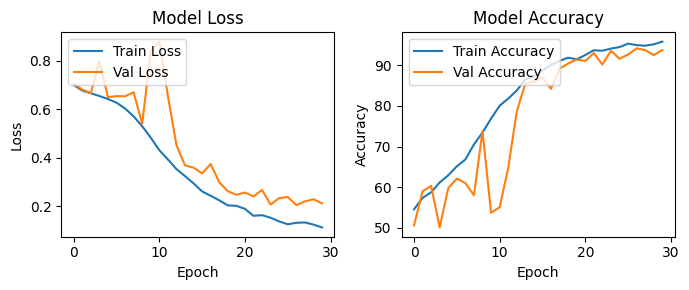

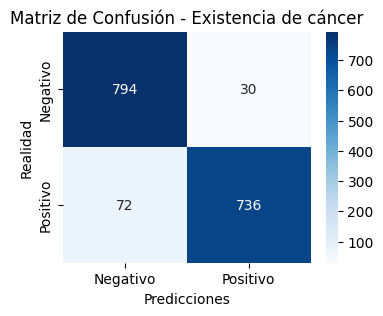

Precisión global: 93.75%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.92      0.96      0.94       824
    Positivo       0.96      0.91      0.94       808

    accuracy                           0.94      1632
   macro avg       0.94      0.94      0.94      1632
weighted avg       0.94      0.94      0.94      1632

Precisión: 0.96
Sensibilidad (Recall): 0.91
F1-Score: 0.94
Accuracy: 0.94
Especificidad: 0.96


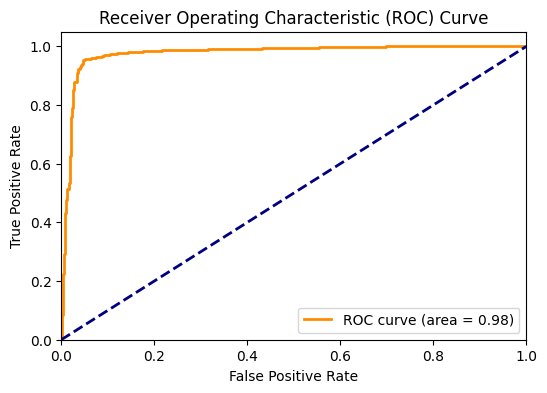

0.976509180044218

In [ ]:
models_list.append("EnhancedCNN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
# Global Contrast Normalization

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)
    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev**2 + 10e-6)

    return gcn_image_tensor

X_tensor_gcn = global_contrast_normalization(X_tensor)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_tensor_gcn, y_tensor, test_size=test_size, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
model = CNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/CNN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 409/409 [00:11<00:00, 35.50it/s]


Train Loss: 0.694, Train Accuracy: 50.60%, Val Loss: 0.6957, Val Accuracy: 49.51%, Time: 12.60 seconds
Validation loss mejorada a 0.695651. Guardando modelo...


Epoch 2/30: 100%|██████████| 409/409 [00:11<00:00, 36.13it/s]


Train Loss: 0.693, Train Accuracy: 50.96%, Val Loss: 0.6970, Val Accuracy: 51.23%, Time: 12.40 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 409/409 [00:11<00:00, 35.44it/s]


Train Loss: 0.688, Train Accuracy: 54.45%, Val Loss: 0.6909, Val Accuracy: 52.94%, Time: 12.60 seconds
Validation loss mejorada a 0.690928. Guardando modelo...


Epoch 4/30: 100%|██████████| 409/409 [00:11<00:00, 36.05it/s]


Train Loss: 0.650, Train Accuracy: 61.67%, Val Loss: 0.6420, Val Accuracy: 63.24%, Time: 12.40 seconds
Validation loss mejorada a 0.642015. Guardando modelo...


Epoch 5/30: 100%|██████████| 409/409 [00:11<00:00, 36.31it/s]


Train Loss: 0.523, Train Accuracy: 73.62%, Val Loss: 0.5089, Val Accuracy: 75.00%, Time: 12.33 seconds
Validation loss mejorada a 0.508930. Guardando modelo...


Epoch 6/30: 100%|██████████| 409/409 [00:11<00:00, 36.12it/s]


Train Loss: 0.306, Train Accuracy: 87.22%, Val Loss: 0.4228, Val Accuracy: 83.64%, Time: 12.38 seconds
Validation loss mejorada a 0.422814. Guardando modelo...


Epoch 7/30: 100%|██████████| 409/409 [00:11<00:00, 36.48it/s]


Train Loss: 0.129, Train Accuracy: 95.20%, Val Loss: 0.4200, Val Accuracy: 87.56%, Time: 12.30 seconds
Validation loss mejorada a 0.420004. Guardando modelo...


Epoch 8/30: 100%|██████████| 409/409 [00:11<00:00, 36.49it/s]


Train Loss: 0.048, Train Accuracy: 98.29%, Val Loss: 0.4494, Val Accuracy: 90.07%, Time: 12.26 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 9/30: 100%|██████████| 409/409 [00:11<00:00, 36.59it/s]


Train Loss: 0.035, Train Accuracy: 98.98%, Val Loss: 0.5871, Val Accuracy: 89.83%, Time: 12.23 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 10/30: 100%|██████████| 409/409 [00:11<00:00, 36.37it/s]


Train Loss: 0.031, Train Accuracy: 99.02%, Val Loss: 0.5347, Val Accuracy: 90.69%, Time: 12.30 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 11/30: 100%|██████████| 409/409 [00:11<00:00, 36.38it/s]


Train Loss: 0.038, Train Accuracy: 98.82%, Val Loss: 0.6075, Val Accuracy: 90.50%, Time: 12.31 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 12/30: 100%|██████████| 409/409 [00:11<00:00, 36.39it/s]


Train Loss: 0.011, Train Accuracy: 99.79%, Val Loss: 0.5372, Val Accuracy: 91.79%, Time: 12.29 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 13/30: 100%|██████████| 409/409 [00:11<00:00, 36.46it/s]


Train Loss: 0.003, Train Accuracy: 99.92%, Val Loss: 0.7804, Val Accuracy: 90.44%, Time: 12.27 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 14/30: 100%|██████████| 409/409 [00:11<00:00, 36.45it/s]


Train Loss: 0.007, Train Accuracy: 99.85%, Val Loss: 0.6408, Val Accuracy: 91.30%, Time: 12.27 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 15/30: 100%|██████████| 409/409 [00:11<00:00, 36.50it/s]


Train Loss: 0.004, Train Accuracy: 99.89%, Val Loss: 1.0333, Val Accuracy: 88.79%, Time: 12.26 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 16/30: 100%|██████████| 409/409 [00:11<00:00, 36.46it/s]


Train Loss: 0.035, Train Accuracy: 98.99%, Val Loss: 0.6469, Val Accuracy: 90.26%, Time: 12.27 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 17/30: 100%|██████████| 409/409 [00:11<00:00, 36.45it/s]


Train Loss: 0.048, Train Accuracy: 98.66%, Val Loss: 0.5423, Val Accuracy: 91.48%, Time: 12.27 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 18/30: 100%|██████████| 409/409 [00:11<00:00, 36.43it/s]


Train Loss: 0.015, Train Accuracy: 99.63%, Val Loss: 0.6130, Val Accuracy: 91.30%, Time: 12.28 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 19/30: 100%|██████████| 409/409 [00:11<00:00, 36.43it/s]


Train Loss: 0.007, Train Accuracy: 99.86%, Val Loss: 0.6569, Val Accuracy: 91.36%, Time: 12.28 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 20/30: 100%|██████████| 409/409 [00:11<00:00, 36.47it/s]


Train Loss: 0.001, Train Accuracy: 100.00%, Val Loss: 0.6994, Val Accuracy: 91.85%, Time: 12.28 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 21/30: 100%|██████████| 409/409 [00:11<00:00, 36.52it/s]


Train Loss: 0.000, Train Accuracy: 100.00%, Val Loss: 0.7501, Val Accuracy: 91.67%, Time: 12.25 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 22/30: 100%|██████████| 409/409 [00:11<00:00, 36.49it/s]


Train Loss: 0.000, Train Accuracy: 100.00%, Val Loss: 0.8371, Val Accuracy: 91.79%, Time: 12.26 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


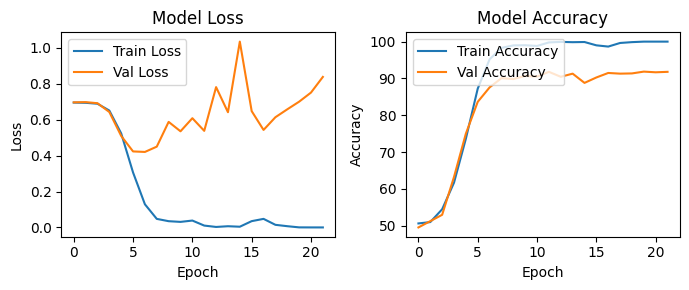

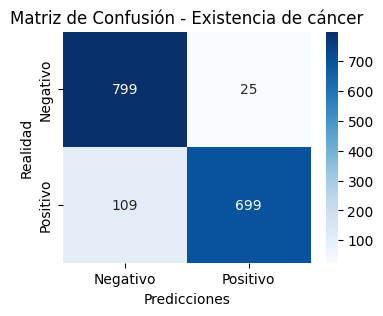

Precisión global: 91.79%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.88      0.97      0.92       824
    Positivo       0.97      0.87      0.91       808

    accuracy                           0.92      1632
   macro avg       0.92      0.92      0.92      1632
weighted avg       0.92      0.92      0.92      1632

Precisión: 0.97
Sensibilidad (Recall): 0.87
F1-Score: 0.91
Accuracy: 0.92
Especificidad: 0.97


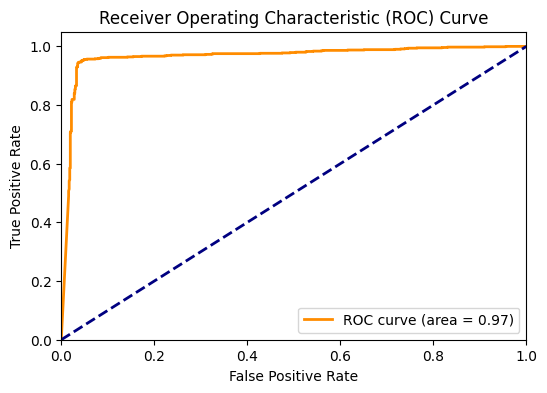

0.9654884708737865

In [ ]:
models_list.append("CNN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/EnhancedCNN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 409/409 [00:16<00:00, 24.11it/s]


Train Loss: 0.701, Train Accuracy: 53.91%, Val Loss: 0.6774, Val Accuracy: 57.29%, Time: 18.28 seconds
Validation loss mejorada a 0.677379. Guardando modelo...


Epoch 2/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.683, Train Accuracy: 56.92%, Val Loss: 0.6997, Val Accuracy: 52.21%, Time: 18.26 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.669, Train Accuracy: 59.05%, Val Loss: 0.6738, Val Accuracy: 55.82%, Time: 18.28 seconds
Validation loss mejorada a 0.673772. Guardando modelo...


Epoch 4/30: 100%|██████████| 409/409 [00:16<00:00, 24.12it/s]


Train Loss: 0.654, Train Accuracy: 60.61%, Val Loss: 0.6629, Val Accuracy: 58.88%, Time: 18.29 seconds
Validation loss mejorada a 0.662904. Guardando modelo...


Epoch 5/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.641, Train Accuracy: 62.85%, Val Loss: 0.6582, Val Accuracy: 60.85%, Time: 18.23 seconds
Validation loss mejorada a 0.658223. Guardando modelo...


Epoch 6/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.624, Train Accuracy: 65.37%, Val Loss: 0.6454, Val Accuracy: 62.44%, Time: 18.29 seconds
Validation loss mejorada a 0.645366. Guardando modelo...


Epoch 7/30: 100%|██████████| 409/409 [00:16<00:00, 24.12it/s]


Train Loss: 0.591, Train Accuracy: 68.34%, Val Loss: 0.5969, Val Accuracy: 66.79%, Time: 18.26 seconds
Validation loss mejorada a 0.596871. Guardando modelo...


Epoch 8/30: 100%|██████████| 409/409 [00:16<00:00, 24.14it/s]


Train Loss: 0.544, Train Accuracy: 72.54%, Val Loss: 0.6113, Val Accuracy: 67.03%, Time: 18.26 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 9/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.497, Train Accuracy: 75.57%, Val Loss: 0.5044, Val Accuracy: 76.35%, Time: 18.24 seconds
Validation loss mejorada a 0.504375. Guardando modelo...


Epoch 10/30: 100%|██████████| 409/409 [00:16<00:00, 24.20it/s]


Train Loss: 0.445, Train Accuracy: 78.87%, Val Loss: 0.5019, Val Accuracy: 76.59%, Time: 18.23 seconds
Validation loss mejorada a 0.501923. Guardando modelo...


Epoch 11/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.392, Train Accuracy: 81.86%, Val Loss: 0.4092, Val Accuracy: 82.29%, Time: 18.30 seconds
Validation loss mejorada a 0.409177. Guardando modelo...


Epoch 12/30: 100%|██████████| 409/409 [00:16<00:00, 24.11it/s]


Train Loss: 0.326, Train Accuracy: 86.71%, Val Loss: 0.4221, Val Accuracy: 81.19%, Time: 18.28 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 13/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.321, Train Accuracy: 86.22%, Val Loss: 0.3494, Val Accuracy: 85.72%, Time: 18.23 seconds
Validation loss mejorada a 0.349414. Guardando modelo...


Epoch 14/30: 100%|██████████| 409/409 [00:16<00:00, 24.24it/s]


Train Loss: 0.274, Train Accuracy: 88.45%, Val Loss: 0.3669, Val Accuracy: 84.56%, Time: 18.17 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 15/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.240, Train Accuracy: 90.33%, Val Loss: 0.3145, Val Accuracy: 87.99%, Time: 18.26 seconds
Validation loss mejorada a 0.314538. Guardando modelo...


Epoch 16/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.222, Train Accuracy: 91.00%, Val Loss: 0.3471, Val Accuracy: 86.40%, Time: 18.24 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 17/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.201, Train Accuracy: 91.76%, Val Loss: 0.3337, Val Accuracy: 86.21%, Time: 18.23 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 18/30: 100%|██████████| 409/409 [00:16<00:00, 24.18it/s]


Train Loss: 0.175, Train Accuracy: 93.14%, Val Loss: 0.2654, Val Accuracy: 90.32%, Time: 18.21 seconds
Validation loss mejorada a 0.265376. Guardando modelo...


Epoch 19/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.170, Train Accuracy: 93.17%, Val Loss: 0.2773, Val Accuracy: 89.71%, Time: 18.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 20/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.149, Train Accuracy: 94.19%, Val Loss: 0.2395, Val Accuracy: 91.67%, Time: 18.23 seconds
Validation loss mejorada a 0.239458. Guardando modelo...


Epoch 21/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.152, Train Accuracy: 94.07%, Val Loss: 0.2199, Val Accuracy: 93.08%, Time: 18.23 seconds
Validation loss mejorada a 0.219915. Guardando modelo...


Epoch 22/30: 100%|██████████| 409/409 [00:16<00:00, 24.19it/s]


Train Loss: 0.140, Train Accuracy: 94.35%, Val Loss: 0.2834, Val Accuracy: 89.52%, Time: 18.22 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 23/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.132, Train Accuracy: 94.85%, Val Loss: 0.2109, Val Accuracy: 93.26%, Time: 18.29 seconds
Validation loss mejorada a 0.210915. Guardando modelo...


Epoch 24/30: 100%|██████████| 409/409 [00:16<00:00, 24.11it/s]


Train Loss: 0.124, Train Accuracy: 95.31%, Val Loss: 0.2672, Val Accuracy: 90.50%, Time: 18.27 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 25/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.115, Train Accuracy: 95.48%, Val Loss: 0.2934, Val Accuracy: 89.52%, Time: 18.24 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 26/30: 100%|██████████| 409/409 [00:16<00:00, 24.22it/s]


Train Loss: 0.106, Train Accuracy: 96.23%, Val Loss: 0.2748, Val Accuracy: 90.62%, Time: 18.18 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 27/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.113, Train Accuracy: 95.80%, Val Loss: 0.2243, Val Accuracy: 92.71%, Time: 18.24 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 28/30: 100%|██████████| 409/409 [00:16<00:00, 24.11it/s]


Train Loss: 0.118, Train Accuracy: 95.69%, Val Loss: 0.2263, Val Accuracy: 92.46%, Time: 18.28 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 29/30: 100%|██████████| 409/409 [00:16<00:00, 24.12it/s]


Train Loss: 0.105, Train Accuracy: 96.09%, Val Loss: 0.2414, Val Accuracy: 91.79%, Time: 18.27 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 30/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.095, Train Accuracy: 96.13%, Val Loss: 0.2076, Val Accuracy: 94.12%, Time: 18.26 seconds
Validation loss mejorada a 0.207602. Guardando modelo...


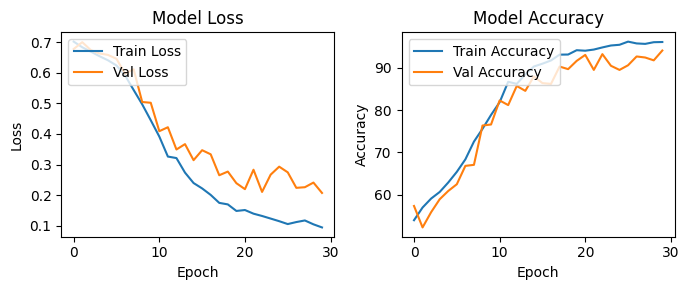

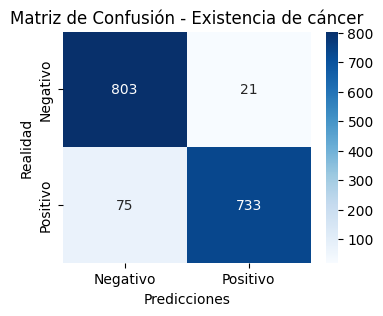

Precisión global: 94.12%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.91      0.97      0.94       824
    Positivo       0.97      0.91      0.94       808

    accuracy                           0.94      1632
   macro avg       0.94      0.94      0.94      1632
weighted avg       0.94      0.94      0.94      1632

Precisión: 0.97
Sensibilidad (Recall): 0.91
F1-Score: 0.94
Accuracy: 0.94
Especificidad: 0.97


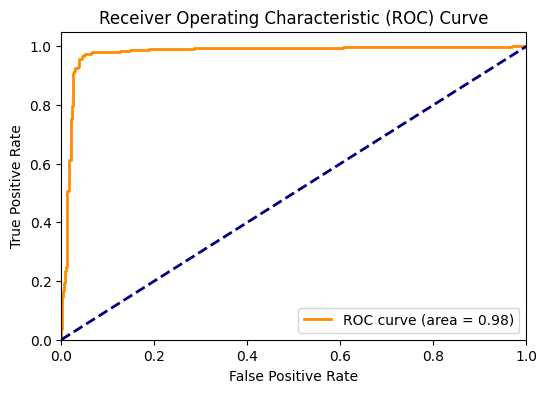

0.9778459338652312

In [ ]:
models_list.append("EnhancedCNN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
from skimage import exposure

def local_contrast_normalization(tensor):
    image = tensor.numpy()

    lcn_images = []
    for i in range(image.shape[0]):
        lcn_image = exposure.equalize_adapthist(image[i], clip_limit=0.03)
        lcn_images.append(lcn_image)

    lcn_tensor = torch.tensor(np.stack(lcn_images))

    return lcn_tensor

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)

    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev**2 + 10e-6)

    return gcn_image_tensor

def LCN_GCN_preprocess(tensor):
    lcn_tensor = local_contrast_normalization(tensor)
    gcn_tensor = global_contrast_normalization(lcn_tensor)

    return gcn_tensor

X_tensor_LCN_GCN = LCN_GCN_preprocess(X_tensor)

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_tensor_LCN_GCN, y_tensor, test_size=test_size, random_state=42)

# Dataset y DataLoader CON LOCAL CONTRAST NORMALIZATION Y GLOBAL CONTRAST NORMALIZATION
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
model = CNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/CNN_LCN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 409/409 [00:11<00:00, 36.20it/s]


Train Loss: 0.680, Train Accuracy: 56.37%, Val Loss: 0.6650, Val Accuracy: 58.88%, Time: 12.36 seconds
Validation loss mejorada a 0.664977. Guardando modelo...


Epoch 2/30: 100%|██████████| 409/409 [00:11<00:00, 36.10it/s]


Train Loss: 0.610, Train Accuracy: 66.17%, Val Loss: 0.5889, Val Accuracy: 69.49%, Time: 12.38 seconds
Validation loss mejorada a 0.588931. Guardando modelo...


Epoch 3/30: 100%|██████████| 409/409 [00:11<00:00, 36.12it/s]


Train Loss: 0.417, Train Accuracy: 80.61%, Val Loss: 0.4889, Val Accuracy: 81.43%, Time: 12.38 seconds
Validation loss mejorada a 0.488874. Guardando modelo...


Epoch 4/30: 100%|██████████| 409/409 [00:11<00:00, 35.91it/s]


Train Loss: 0.194, Train Accuracy: 92.18%, Val Loss: 0.4141, Val Accuracy: 86.27%, Time: 12.45 seconds
Validation loss mejorada a 0.414140. Guardando modelo...


Epoch 5/30: 100%|██████████| 409/409 [00:11<00:00, 35.93it/s]


Train Loss: 0.077, Train Accuracy: 97.46%, Val Loss: 0.6294, Val Accuracy: 87.50%, Time: 12.44 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 6/30: 100%|██████████| 409/409 [00:11<00:00, 36.18it/s]


Train Loss: 0.033, Train Accuracy: 98.76%, Val Loss: 0.6424, Val Accuracy: 88.91%, Time: 12.37 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 7/30: 100%|██████████| 409/409 [00:11<00:00, 36.30it/s]


Train Loss: 0.028, Train Accuracy: 99.10%, Val Loss: 0.6706, Val Accuracy: 90.38%, Time: 12.33 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 8/30: 100%|██████████| 409/409 [00:11<00:00, 36.30it/s]


Train Loss: 0.028, Train Accuracy: 99.34%, Val Loss: 0.7601, Val Accuracy: 88.54%, Time: 12.33 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 9/30: 100%|██████████| 409/409 [00:11<00:00, 36.28it/s]


Train Loss: 0.014, Train Accuracy: 99.60%, Val Loss: 0.8298, Val Accuracy: 89.22%, Time: 12.33 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 10/30: 100%|██████████| 409/409 [00:11<00:00, 36.14it/s]


Train Loss: 0.036, Train Accuracy: 98.87%, Val Loss: 0.7062, Val Accuracy: 89.03%, Time: 12.38 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 11/30: 100%|██████████| 409/409 [00:11<00:00, 36.22it/s]


Train Loss: 0.013, Train Accuracy: 99.57%, Val Loss: 0.8130, Val Accuracy: 89.83%, Time: 12.35 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 12/30: 100%|██████████| 409/409 [00:11<00:00, 36.36it/s]


Train Loss: 0.015, Train Accuracy: 99.56%, Val Loss: 0.8171, Val Accuracy: 90.87%, Time: 12.30 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 13/30: 100%|██████████| 409/409 [00:11<00:00, 36.24it/s]


Train Loss: 0.003, Train Accuracy: 99.89%, Val Loss: 0.8693, Val Accuracy: 90.38%, Time: 12.34 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 14/30: 100%|██████████| 409/409 [00:11<00:00, 36.30it/s]


Train Loss: 0.020, Train Accuracy: 99.39%, Val Loss: 0.9088, Val Accuracy: 87.50%, Time: 12.32 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 15/30: 100%|██████████| 409/409 [00:11<00:00, 36.36it/s]


Train Loss: 0.008, Train Accuracy: 99.80%, Val Loss: 0.9202, Val Accuracy: 88.73%, Time: 12.30 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 16/30: 100%|██████████| 409/409 [00:11<00:00, 36.39it/s]


Train Loss: 0.011, Train Accuracy: 99.72%, Val Loss: 0.7771, Val Accuracy: 90.50%, Time: 12.29 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 17/30: 100%|██████████| 409/409 [00:11<00:00, 36.34it/s]


Train Loss: 0.030, Train Accuracy: 99.04%, Val Loss: 0.8111, Val Accuracy: 90.75%, Time: 12.30 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 18/30: 100%|██████████| 409/409 [00:11<00:00, 36.36it/s]


Train Loss: 0.015, Train Accuracy: 99.56%, Val Loss: 0.7116, Val Accuracy: 90.20%, Time: 12.30 seconds
EarlyStopping no mejoró en 14 épocas


Epoch 19/30: 100%|██████████| 409/409 [00:11<00:00, 36.37it/s]


Train Loss: 0.010, Train Accuracy: 99.65%, Val Loss: 0.9039, Val Accuracy: 89.52%, Time: 12.29 seconds
EarlyStopping no mejoró en 15 épocas
Early Stopping activado. Proceso detenido!


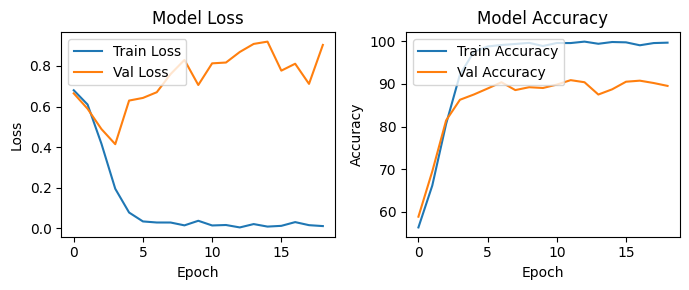

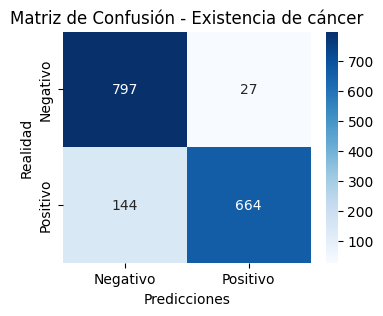

Precisión global: 89.52%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.85      0.97      0.90       824
    Positivo       0.96      0.82      0.89       808

    accuracy                           0.90      1632
   macro avg       0.90      0.89      0.89      1632
weighted avg       0.90      0.90      0.89      1632

Precisión: 0.96
Sensibilidad (Recall): 0.82
F1-Score: 0.89
Accuracy: 0.90
Especificidad: 0.97


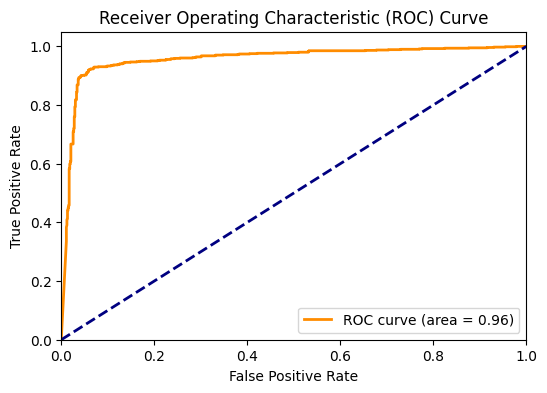

0.9571194907718928

In [ ]:
models_list.append("CNN-LCN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/CNN_LCN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=15, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.701, Train Accuracy: 55.24%, Val Loss: 0.6699, Val Accuracy: 59.25%, Time: 18.23 seconds
Validation loss mejorada a 0.669925. Guardando modelo...


Epoch 2/30: 100%|██████████| 409/409 [00:16<00:00, 24.14it/s]


Train Loss: 0.664, Train Accuracy: 59.87%, Val Loss: 0.6633, Val Accuracy: 57.90%, Time: 18.26 seconds
Validation loss mejorada a 0.663341. Guardando modelo...


Epoch 3/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.642, Train Accuracy: 62.84%, Val Loss: 0.6513, Val Accuracy: 61.52%, Time: 18.24 seconds
Validation loss mejorada a 0.651278. Guardando modelo...


Epoch 4/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.623, Train Accuracy: 65.11%, Val Loss: 0.6327, Val Accuracy: 61.58%, Time: 18.29 seconds
Validation loss mejorada a 0.632698. Guardando modelo...


Epoch 5/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.590, Train Accuracy: 68.35%, Val Loss: 0.6016, Val Accuracy: 65.99%, Time: 18.29 seconds
Validation loss mejorada a 0.601591. Guardando modelo...


Epoch 6/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.541, Train Accuracy: 71.94%, Val Loss: 0.5568, Val Accuracy: 71.51%, Time: 18.27 seconds
Validation loss mejorada a 0.556785. Guardando modelo...


Epoch 7/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.474, Train Accuracy: 77.77%, Val Loss: 0.5195, Val Accuracy: 74.33%, Time: 18.23 seconds
Validation loss mejorada a 0.519509. Guardando modelo...


Epoch 8/30: 100%|██████████| 409/409 [00:16<00:00, 24.14it/s]


Train Loss: 0.409, Train Accuracy: 81.71%, Val Loss: 0.4514, Val Accuracy: 80.82%, Time: 18.25 seconds
Validation loss mejorada a 0.451419. Guardando modelo...


Epoch 9/30: 100%|██████████| 409/409 [00:16<00:00, 24.15it/s]


Train Loss: 0.348, Train Accuracy: 84.60%, Val Loss: 0.4045, Val Accuracy: 82.90%, Time: 18.24 seconds
Validation loss mejorada a 0.404513. Guardando modelo...


Epoch 10/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.311, Train Accuracy: 86.06%, Val Loss: 0.3834, Val Accuracy: 83.82%, Time: 18.23 seconds
Validation loss mejorada a 0.383393. Guardando modelo...


Epoch 11/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.253, Train Accuracy: 89.84%, Val Loss: 0.3968, Val Accuracy: 83.39%, Time: 18.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 12/30: 100%|██████████| 409/409 [00:16<00:00, 24.15it/s]


Train Loss: 0.217, Train Accuracy: 91.37%, Val Loss: 0.3203, Val Accuracy: 87.75%, Time: 18.24 seconds
Validation loss mejorada a 0.320314. Guardando modelo...


Epoch 13/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.199, Train Accuracy: 92.18%, Val Loss: 0.3808, Val Accuracy: 84.93%, Time: 18.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 14/30: 100%|██████████| 409/409 [00:16<00:00, 24.17it/s]


Train Loss: 0.182, Train Accuracy: 92.73%, Val Loss: 0.3309, Val Accuracy: 87.93%, Time: 18.22 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 15/30: 100%|██████████| 409/409 [00:16<00:00, 24.24it/s]


Train Loss: 0.157, Train Accuracy: 94.16%, Val Loss: 0.4051, Val Accuracy: 83.88%, Time: 18.18 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 16/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.163, Train Accuracy: 93.26%, Val Loss: 0.2653, Val Accuracy: 91.36%, Time: 18.23 seconds
Validation loss mejorada a 0.265276. Guardando modelo...


Epoch 17/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.154, Train Accuracy: 93.77%, Val Loss: 0.3307, Val Accuracy: 87.62%, Time: 18.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 18/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.131, Train Accuracy: 95.20%, Val Loss: 0.3311, Val Accuracy: 87.87%, Time: 18.23 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 19/30: 100%|██████████| 409/409 [00:16<00:00, 24.24it/s]


Train Loss: 0.120, Train Accuracy: 95.37%, Val Loss: 0.3548, Val Accuracy: 86.40%, Time: 18.17 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 20/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.122, Train Accuracy: 95.32%, Val Loss: 0.3470, Val Accuracy: 87.81%, Time: 18.25 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 21/30: 100%|██████████| 409/409 [00:17<00:00, 24.05it/s]


Train Loss: 0.121, Train Accuracy: 95.25%, Val Loss: 0.3546, Val Accuracy: 87.68%, Time: 18.33 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 22/30: 100%|██████████| 409/409 [00:17<00:00, 24.05it/s]


Train Loss: 0.106, Train Accuracy: 95.97%, Val Loss: 0.2870, Val Accuracy: 90.69%, Time: 18.31 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 23/30: 100%|██████████| 409/409 [00:16<00:00, 24.12it/s]


Train Loss: 0.105, Train Accuracy: 95.77%, Val Loss: 0.3403, Val Accuracy: 88.24%, Time: 18.26 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 24/30: 100%|██████████| 409/409 [00:16<00:00, 24.10it/s]


Train Loss: 0.101, Train Accuracy: 96.27%, Val Loss: 0.3219, Val Accuracy: 89.15%, Time: 18.28 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 25/30: 100%|██████████| 409/409 [00:16<00:00, 24.16it/s]


Train Loss: 0.093, Train Accuracy: 96.36%, Val Loss: 0.2987, Val Accuracy: 90.56%, Time: 18.24 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 26/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.093, Train Accuracy: 96.52%, Val Loss: 0.2940, Val Accuracy: 90.69%, Time: 18.26 seconds
EarlyStopping no mejoró en 10 épocas


Epoch 27/30: 100%|██████████| 409/409 [00:16<00:00, 24.14it/s]


Train Loss: 0.087, Train Accuracy: 96.99%, Val Loss: 0.4365, Val Accuracy: 85.29%, Time: 18.25 seconds
EarlyStopping no mejoró en 11 épocas


Epoch 28/30: 100%|██████████| 409/409 [00:16<00:00, 24.20it/s]


Train Loss: 0.082, Train Accuracy: 97.05%, Val Loss: 0.4433, Val Accuracy: 85.91%, Time: 18.21 seconds
EarlyStopping no mejoró en 12 épocas


Epoch 29/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.089, Train Accuracy: 96.64%, Val Loss: 0.3070, Val Accuracy: 90.26%, Time: 18.25 seconds
EarlyStopping no mejoró en 13 épocas


Epoch 30/30: 100%|██████████| 409/409 [00:16<00:00, 24.13it/s]


Train Loss: 0.089, Train Accuracy: 96.65%, Val Loss: 0.3268, Val Accuracy: 89.22%, Time: 18.26 seconds
EarlyStopping no mejoró en 14 épocas


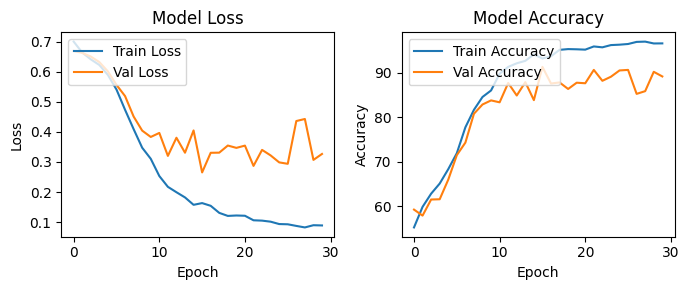

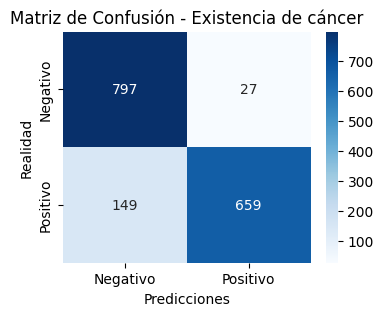

Precisión global: 89.22%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.84      0.97      0.90       824
    Positivo       0.96      0.82      0.88       808

    accuracy                           0.89      1632
   macro avg       0.90      0.89      0.89      1632
weighted avg       0.90      0.89      0.89      1632

Precisión: 0.96
Sensibilidad (Recall): 0.82
F1-Score: 0.88
Accuracy: 0.89
Especificidad: 0.97


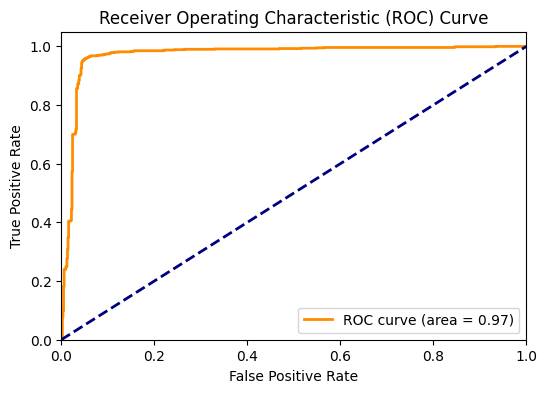

0.9705673844083438

In [ ]:
models_list.append("EnhancedCNN-LCN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)